# Import packages

In [6]:
from math import log10, floor
import pandas as pd
import numpy as np

import scipy.stats as stats

from sklearn.linear_model import LinearRegression

from sklearn import datasets, metrics
from sklearn.preprocessing import StandardScaler
from sklearn import svm, linear_model, datasets
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict, KFold, StratifiedKFold
from sklearn.metrics import roc_curve, auc

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn import datasets, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.externals.six import StringIO
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, GradientBoostingRegressor, AdaBoostClassifier, RandomForestRegressor
from sklearn.datasets import make_classification

from sklearn.metrics import classification_report, confusion_matrix, precision_score
from IPython.display import Image
from sklearn.tree import export_graphviz

import pydotplus

import pickle

import warnings
warnings.simplefilter("ignore")

import seaborn as sns
import matplotlib.pyplot as plt; plt.rcdefaults()
from matplotlib import pyplot as plt

np.set_printoptions(precision=4)

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Load data

In [16]:
# Decided to use .sample - the original dataset is large and takes long time to run models
restaurants = pd.read_pickle('/Users/mai/Desktop/yelp_dataset/to_submit/restaurants_clean.pickle')

In [18]:
restaurants.head()

,business_id,review_id,minyear,maxyear,estimated_opearating_years,total_checkins,total_checkinyear_count,city,business_status,latitude,...,food_type_Seafood,food_type_Soup,food_type_Steakhouses,food_type_Sushi Bars,food_type_Tacos,food_type_Tapas Bars,food_type_Uzbek,food_type_Waffles,food_type_Wraps,prediction_col
1,--6MefnULPED_I942VcFNA,46,2011,2018,7,167,8,Richmond Hill,1,43.841694,...,0,0,0,0,0,0,0,0,0,successful
2,--7zmmkVg-IMGaXbuVd0SQ,59,2014,2018,4,180,5,Huntersville,1,35.437106,...,0,0,0,0,0,0,0,0,0,successful
3,--9e1ONYQuAa-CB_Rrw7Tw,1661,2010,2018,8,2770,9,Las Vegas,1,36.123183,...,0,0,1,0,0,0,0,0,0,successful
4,--DaPTJW3-tB1vP-PfdTEg,49,2012,2018,6,95,7,Toronto,1,43.677807,...,0,0,0,0,0,0,0,0,0,successful
5,--FBCX-N37CMYDfs790Bnw,142,2010,2018,8,528,9,Henderson,1,35.978679,...,0,0,0,0,0,0,0,0,0,successful


# Create target variables 

In [19]:
restaurants.prediction_col = restaurants.prediction_col.replace('successful', 1)
restaurants.prediction_col = restaurants.prediction_col.replace('failed', 0)

# Check data type

In [20]:
# Use pandas.qcut to categorise checkin count data
restaurants['total_checkins_qcut'] = pd.qcut(restaurants['total_checkins'], 3, labels=['low', 'medium', 'high'])

In [21]:
# Use pandas.qcut to categorise review count data
restaurants['review_count_per_business_qcut'] = pd.qcut(restaurants['review_count_per_business'], 3, labels=['low', 'medium', 'high'])

In [22]:
# Use pandas.qcut to categorise star rating data
restaurants['average_stars_per_business_qcut'] = pd.qcut(restaurants['average_stars_per_business'], 3, labels=['low', 'medium', 'high'])

In [23]:
# Check data type of all the columns
object_col = []
float_col = []
int_col = []
for column in restaurants.columns: 
    if restaurants[column].dtype == 'O':
        object_col.append(column)
    elif restaurants[column].dtype == 'float64':
        float_col.append(column)
    elif restaurants[column].dtype == 'int64':
        int_col.append(column)
    else:
        pass
#print('object_col:', object_col)
#print('---------')
#print('float_col:', float_col)
#print('---------')
#print('int_col:', int_col)

# Check correlation values

In [25]:
crr_matrix = restaurants.corr().abs()

# Too big to show on heatmap thus I created a DataFrame
crr_matrix2 = crr_matrix.unstack()
crr_df = pd.DataFrame(crr_matrix2).reset_index()
crr_df.columns = ['variable_1', 'variable_2', 'value']
crr_df[crr_df.variable_1.str.contains('prediction_col') == True].sort_values(by='value', ascending=False).head()

,variable_1,variable_2,value
38808,prediction_col,prediction_col,1.000000
38618,prediction_col,business_status,1.000000
38614,prediction_col,maxyear,0.735969
38615,prediction_col,estimated_opearating_years,0.657117
38617,prediction_col,total_checkinyear_count,0.596207


# Remove columns unnecessary for building models

In [28]:
# List up columns to drop
columns_to_drop = [
           'US_state', 'business_type_Restaurants', 'business_id', 'city', 'business_name', 
           'latitude', 'longitude', 'average_stars_per_business',
           'review_id', 'minyear', 'maxyear', 'estimated_opearating_years', 
           'total_checkins', 'total_checkinyear_count', 
           'acceptsinsurance_true', 'acceptsinsurance_none',
           'business_status', 'review_count_per_business', 
           ]

In [29]:
# Drop the columns
restaurants.drop(columns_to_drop, axis=1, inplace=True)

# Dummify columns

In [30]:
restaurants = pd.get_dummies(restaurants, columns=['total_checkins_qcut', 'review_count_per_business_qcut', 'average_stars_per_business_qcut'], drop_first=True)

# Pickle results to save time

In [31]:
# Pickle results to avoid running all the above code again - it took hours to finish running
restaurants.to_pickle('restaurants_for_classification_models.pickle')

In [32]:
# Load data
restaurants = pd.read_pickle('/Users/mai/Desktop/yelp_dataset/to_submit/restaurants_for_classification_models.pickle')

In [33]:
# Check the data
restaurants.head()

,agesallowed_none,alcohol_beer_and_wine,alcohol_full_bar,alcohol_not_available,alcohol_none,bring_your_own_bottle_true,bring_your_own_bottle_corkage_not_charged,bring_your_own_bottle_corkage_yes,bring_your_own_bottle_corkage_yes_free_,bring_your_own_bottle_corkage_unknown,...,food_type_Uzbek,food_type_Waffles,food_type_Wraps,prediction_col,total_checkins_qcut_medium,total_checkins_qcut_high,review_count_per_business_qcut_medium,review_count_per_business_qcut_high,average_stars_per_business_qcut_medium,average_stars_per_business_qcut_high
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,1,0,1,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,1,0,1,1,0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,1,0,1,0,1,1,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,1,0,0,1,1,0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,1,0,1,1,0


# Prepare data to build models

In [34]:
# Set up y variable
y = restaurants.pop('prediction_col')

In [35]:
# Check the length
len(y)

57484

In [36]:
# Specify X variables
X = restaurants

In [37]:
# Check the length
len(X.columns)

188

# Check baseline

In [38]:
baseline = y.value_counts(normalize=True).max()
baseline

0.6712824438104517

# Build models to predict closure status (1 = successful, 0 = failed)

In [39]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

In [40]:
scaler = StandardScaler()

In [41]:
# Create a function to show confusion matrix
def predictions_confusion(model, X, y):

    yhat = model.predict(X)
    yhat_pp = model.predict_proba(X)

    conmat = np.array(confusion_matrix(y, yhat, labels=[1, 0]))

    confusion = pd.DataFrame(conmat, index=['1', '0'],
                             columns=['predicted_1', 'predicted_0'])
    return yhat, yhat_pp, confusion

## Use a logistic regression with a Ridge penalty

In [44]:
# Prepare the datasets for modeling
Xr = X.copy()

Xr_train, Xr_test, y_train, y_test = train_test_split(Xr, y, stratify=y, test_size=0.5, random_state=1)

Xr_train = scaler.fit_transform(Xr_train)
Xr_test = scaler.transform(Xr_test)

/Users/mai/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/mai/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/mai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  


In [45]:
# Instantiate the model
lr_ridge = LogisticRegressionCV(penalty='l2', Cs=100, cv=kf)

In [46]:
# Fit the model
lr_ridge.fit(Xr_train, y_train)

LogisticRegressionCV(Cs=100, class_weight=None,
           cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [48]:
# Find the C_ value, and check train, test, cross-validation scores
#print(lr_ridge.C_)
train_lr_ridge = lr_ridge.score(Xr_train, y_train)
print(train_lr_ridge)

test_lr_ridge = lr_ridge.score(Xr_test, y_test)
print(test_lr_ridge)

cv_scores_lr_ridge = cross_val_score(lr_ridge, Xr_train, y_train, cv=5).mean()
print(cv_scores_lr_ridge)

0.7453204369911628
0.7388142787558277
0.7416674231265461


In [49]:
# Check the baseline
baseline

0.6712824438104517

In [50]:
# Check precision and recall scores
yhat_lr_ridge = lr_ridge.predict(Xr_test)
yhat_pp_ridge = lr_ridge.predict_proba(Xr_test)
print(classification_report(y_test, yhat_lr_ridge))

              precision    recall  f1-score   support

           0       0.66      0.42      0.51      9448
           1       0.76      0.90      0.82     19294

   micro avg       0.74      0.74      0.74     28742
   macro avg       0.71      0.66      0.67     28742
weighted avg       0.73      0.74      0.72     28742



In [ ]:
#precision_score(y_true, y_pred, average='macro') 

In [193]:
# Create a confusion matrix
yhat_ridge = lr_ridge.predict(Xr_test)
yhat_pp_ridge = lr_ridge.predict_proba(Xr_test)

yhat_ridge, yhat_pp_ridge, confusion_ridge = predictions_confusion(
    lr_ridge, Xr_test, y_test)
confusion_ridge

,predicted_1,predicted_0
1,17275,2019
0,5488,3960


In [ ]:
# Create a DataFrame to look at the coefficients
coef_df_lr_ridge = pd.DataFrame({'feature': X.columns,
                        'coef': lr_ridge.coef_[0],
                        'abs_coef': np.abs(lr_ridge.coef_[0])})

# Sort by absolute value of coefficient (magnitude)
coef_df_lr_ridge = coef_df_lr_ridge.sort_values(by='abs_coef', ascending=False)

# Use a logistic regression with a Lasso penalty

In [44]:
# Prepare the datasets for modeling
yl = y.copy()
Xl = X.copy()

Xl_train, Xl_test, yl_train, yl_test = train_test_split(Xl, yl, stratify=yl, test_size=0.5, random_state=1)

Xl_train = scaler.fit_transform(Xl_train)
Xl_test = scaler.transform(Xl_test)

In [45]:
# Instantiate the model
lr_lasso = LogisticRegressionCV(penalty='l1', solver='liblinear', Cs=10, cv=kf)

# Fit the model
lr_lasso.fit(Xl_train, yl_train)

LogisticRegressionCV(Cs=10, class_weight=None,
           cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
           random_state=None, refit=True, scoring=None, solver='liblinear',
           tol=0.0001, verbose=0)

In [14]:
# Define the best model
lasso_best = LogisticRegression(C=lr_lasso.C_[0], penalty='l1', solver='liblinear')

In [15]:
# Check the evaluation scores
print(lr_lasso.C_)
print(lr_lasso.score(Xl_train, yl_train))
print(lr_lasso.score(Xl_test, yl_test))

[0.3594]
0.7447985526407348
0.7382923944053997


In [16]:
# Check the cv scores
cv_scores = cross_val_score(lasso_best, Xl_train, yl_train, cv=5).mean()
print(cv_scores)

0.7409019939592455


In [46]:
# Check precision and recall scores
yhat_lr_lasso = lr_lasso.predict(Xl_test)
yhat_pp_lasso = lr_lasso.predict_proba(Xl_test)
print(classification_report(yl_test, yhat_lr_lasso))

              precision    recall  f1-score   support

           0       0.65      0.45      0.53      9448
           1       0.76      0.88      0.82     19294

   micro avg       0.74      0.74      0.74     28742
   macro avg       0.71      0.66      0.67     28742
weighted avg       0.73      0.74      0.72     28742



In [47]:
# Check the misclassified items
pred_list_lr_lasso = lr_lasso.predict_proba(Xl_train)
pred_result_lr_lasso = pd.DataFrame(pred_list_lr_lasso, yl_train)
pred_result_lr_lasso['actual'] = lr_lasso.predict(Xl_train)
pred_result_lr_lasso.reset_index(inplace=True)

misclassified_lr_lasso = pred_result_lr_lasso[pred_result_lr_lasso.prediction_col != pred_result_lr_lasso.actual]
misclassified_lr_lasso = misclassified_lr_lasso.reindex(columns=['prediction_col', 'actual', 0, 1])
misclassified_lr_lasso['difference'] = (misclassified_lr_lasso[0] - misclassified_lr_lasso[1]).round(2)
misclassified_lr_lasso[:5]

,prediction_col,actual,0,1,difference
0,0,1,0.189807,0.810193,-0.62
4,0,1,0.152256,0.847744,-0.70
5,0,1,0.063981,0.936019,-0.87
6,0,1,0.393020,0.606980,-0.21
33,0,1,0.245901,0.754099,-0.51


In [109]:
# Check the confusion matrix
yhat_lasso = lr_lasso.predict(Xl_test)
yhat_pp_lasso = lr_lasso.predict_proba(Xl_test)

yhat_lasso, yhat_pp_lasso, confusion_lasso = predictions_confusion(
    lr_lasso, Xl_test, yl_test)
confusion_lasso

,predicted_1,predicted_0
1,17003,2291
0,5231,4217


In [20]:
# Create a DataFrame to look at the coefficients
coef_df_lr_lasso = pd.DataFrame({'feature': Xl.columns,
                        'coef': lr_lasso.coef_[0],
                        'abs_coef': np.abs(lr_lasso.coef_[0])})

# Sort by absolute value of coefficient (magnitude)
coef_df_lr_lasso = coef_df_lr_lasso.sort_values(by='abs_coef', ascending=False)
coef_df_lr_lasso.head()

,feature,coef,abs_coef
185,total_checkins_qcut_high,0.462430,0.462430
13,bikeparking_true,0.454952,0.454952
187,review_count_per_business_qcut_high,0.348677,0.348677
156,food_type_Fast Food,0.266296,0.266296
17,businessacceptscreditcards_true,-0.242067,0.242067


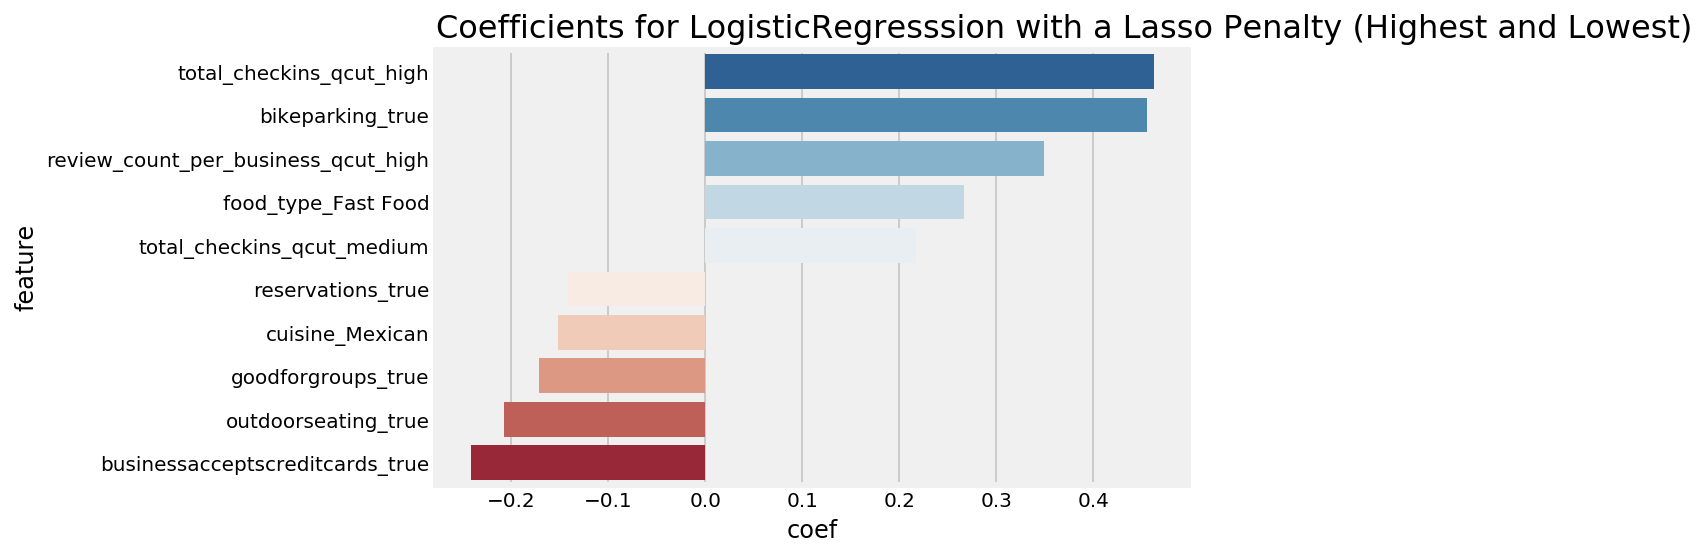

In [31]:
# Plot the coefficient table
sort_coef = pd.concat([coef_df_lr_lasso.sort_values(by='coef', ascending=False).head(5),
                      coef_df_lr_lasso.sort_values(by='coef', ascending=False).tail(5)])
sns.barplot(y = sort_coef.feature, x = sort_coef.coef, palette = "RdBu_r")
plt.title("Coefficients for LogisticRegresssion with a Lasso Penalty (Highest and Lowest)", loc = 'left', fontsize = 16)
plt.show()

In [21]:
# Pickle results to avoid running all the above code again - it took hours to finish running
coef_df_lr_lasso.to_pickle('coef_df_lr_lasso.pickle')

In [22]:
# Save the data as csv
coef_df_lr_lasso.to_csv('coef_df_lr_lasso.csv')

# Use a gridsearch with logistic regression

In [43]:
# Prepare the datasets for modeling
Xlrcv = X.copy()
ylrcv = y.copy()

Xlrcv_train, Xlrcv_test, ylrcv_train, ylrcv_test = train_test_split(Xlrcv, ylrcv, stratify=ylrcv, test_size=0.5, random_state=1)

Xlrcv_train = scaler.fit_transform(Xlrcv_train)
Xlrcv_test = scaler.transform(Xlrcv_test)

In [44]:
# Instantiate the model
lrcv = LogisticRegressionCV(solver='lbfgs', max_iter=1000)

In [45]:
# Fill the dictionary of parameters
gs_params = {'penalty': ['l1', 'l2'], # I want to test with the two penalties
             'solver': ['liblinear'], # I want to use liblinear when I use l1
             #'C': np.logspace(-3, 0, 10)
            } # And I want to use -3 to 0 as a regularization strength which is like alphas

# Create your gridsearch object
lrcv_gridsearch = GridSearchCV(lrcv,
                             gs_params,
                             n_jobs=2, 
                             cv=5, 
                             verbose=1)

In [46]:
# Fit your gridsearch object on your training data
lrcv_gridsearch.fit(Xlrcv_train, ylrcv_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  5.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=1000,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [28]:
# Score your best estimator on the testing data
lrcv_gridsearch.score(Xlrcv_train, ylrcv_train)

0.7446941757706492

In [223]:
# Score your best estimator on the testing data
lrcv_gridsearch.score(Xlrcv_test, ylrcv_test)

0.738570732725628

In [225]:
# Check the baseline
baseline

0.6712824438104517

In [224]:
# Find the mean of those cross-validated scores
cross_val_score(lrcv, Xlrcv_train, ylrcv_train, cv=5).mean()

0.7413890533386203

In [47]:
# Assign the best estimator to a variable
best_lrcv = lrcv_gridsearch.best_estimator_

In [227]:
# Find the best mean cross-validated score that your gridsearch found
lrcv_gridsearch.best_score_

0.74159766195811

In [228]:
# Find the best hyperparameters that your gridsearch found
lrcv_gridsearch.best_params_

{'penalty': 'l1', 'solver': 'liblinear'}

In [229]:
# Check precision and recall scores
yhat_lrcv_gridsearch = lrcv_gridsearch.predict(Xlrcv_test)
yhat_pp_lrcv_gridsearch = lrcv_gridsearch.predict_proba(Xlrcv_test)
print(classification_report(ylrcv_test, yhat_lrcv_gridsearch))

              precision    recall  f1-score   support

           0       0.65      0.45      0.53      9448
           1       0.77      0.88      0.82     19294

   micro avg       0.74      0.74      0.74     28742
   macro avg       0.71      0.66      0.67     28742
weighted avg       0.73      0.74      0.72     28742



In [48]:
# Create a DataFrame to look at the coefficients
coef_df_grid = pd.DataFrame({'feature': Xlrcv.columns,
                        'coef': best_lrcv.coef_[0],
                        'abs_coef': np.abs(best_lrcv.coef_[0])})

In [49]:
# Sort by absolute value of coefficient (magnitude)
coef_df_grid_lrcv = coef_df_grid.sort_values(by='abs_coef', ascending=False)
coef_df_grid_lrcv.head()

,feature,coef,abs_coef
183,total_checkins_qcut_high,0.464802,0.464802
11,bikeparking_true,0.455444,0.455444
185,review_count_per_business_qcut_high,0.351114,0.351114
154,food_type_Fast Food,0.265406,0.265406
15,businessacceptscreditcards_true,-0.242964,0.242964


# Use a KNeighbors Classifier

In [233]:
# Prepare the datasets
yknn = y.copy()
Xknn = X.copy()

Xknn_train, Xknn_test, yknn_train, yknn_test = train_test_split(Xknn, yknn, stratify=yknn, test_size=0.5, random_state=1)

Xknn_train = scaler.fit_transform(Xknn_train)
Xknn_test = scaler.transform(Xknn_test)

In [234]:
# Instantiate the model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(Xknn_train, yknn_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [235]:
# Check the evaluation scores
print(knn.score(Xknn_train, yknn_train))
print(knn.score(Xknn_test, yknn_test))

0.7974740797439287
0.7102150163523763


In [236]:
# Check the cv score
print(cross_val_score(knn, Xknn_train, yknn_train, cv=5, n_jobs=1).mean())

0.7057267556298321


In [237]:
# Check precision and recall scores
yhat_knn = knn.predict(Xknn_test)
yhat_pp_knn = knn.predict_proba(Xknn_test)
print(classification_report(yknn_test, yhat_knn))

              precision    recall  f1-score   support

           0       0.57      0.48      0.52      9448
           1       0.76      0.82      0.79     19294

   micro avg       0.71      0.71      0.71     28742
   macro avg       0.67      0.65      0.66     28742
weighted avg       0.70      0.71      0.70     28742



# Use an Ada Boost Classifier

In [238]:
# Create the datasets
yab = y.copy()
Xab = X.copy()

Xab_train, Xab_test, yab_train, yab_test = train_test_split(Xab, yab, stratify=yab, test_size=0.5, random_state=1)

Xab_train = scaler.fit_transform(Xab_train)
Xab_test = scaler.transform(Xab_test)

In [239]:
# Fit the model
base_estimator = DecisionTreeClassifier(max_depth=3)
ab_model = AdaBoostClassifier(base_estimator=base_estimator,
                           n_estimators=100,
                           random_state=1)
ab_model.fit(Xab_train, yab_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=100, random_state=1)

In [240]:
# Check the evaluation scores
print(ab_model.score(Xab_train, yab_train))
print(cross_val_score(ab_model, Xab_train, yab_train, cv=5).mean())
print(ab_model.score(Xab_test, yab_test))
print(pd.DataFrame(ab_model.staged_predict(Xab_test)
                   ).T.apply(lambda x: accuracy_score(yab_test, x),
                             axis=0)[ab_model.n_estimators-1])

0.779034166028808
0.7491127106503348
0.7510611648458702
0.7510611648458702


In [242]:
# Check the feature importance values
ab_model.feature_importances_[:10]

array([0.    , 0.0027, 0.    , 0.0014, 0.0068, 0.0061, 0.0027, 0.0003,
       0.0062, 0.0007])

In [241]:
# Create a feature importance table
ab_model_result = pd.DataFrame(ab_model.feature_importances_,
             columns=['importance'],
             #index=Xab.feature_names
             ).sort_values(by='importance', ascending=False
                           )

In [243]:
# Check precision and recall scores
yhat_ab_model = ab_model.predict(Xab_test)
yhat_pp_ab_model = ab_model.predict_proba(Xab_test)
print(classification_report(yab_test, yhat_ab_model))

              precision    recall  f1-score   support

           0       0.65      0.53      0.58      9448
           1       0.79      0.86      0.82     19294

   micro avg       0.75      0.75      0.75     28742
   macro avg       0.72      0.69      0.70     28742
weighted avg       0.74      0.75      0.74     28742



# Use a Gradient Boosting Classifier

In [54]:
# Prepare the datasets
ygb = y.copy()
Xgb = X.copy()

Xgb_train, Xgb_test, ygb_train, ygb_test = train_test_split(Xgb, ygb, stratify=ygb, test_size=0.5, random_state=1)

Xgb_train = scaler.fit_transform(Xgb_train)
Xgb_test = scaler.transform(Xgb_test)

In [55]:
# Fit the model
gb_model = GradientBoostingClassifier(n_estimators=100,
                                      criterion='mse',
                                      loss='exponential',
                                      max_depth=3,
                                      learning_rate=1.0, # Put the importance of weights of earlier models 
                                      random_state=1,
                                      validation_fraction=0.1,
                                      n_iter_no_change=20)

gb_model.fit(Xgb_train, ygb_train)

GradientBoostingClassifier(criterion='mse', init=None, learning_rate=1.0,
              loss='exponential', max_depth=3, max_features=None,
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, n_iter_no_change=20, presort='auto',
              random_state=1, subsample=1.0, tol=0.0001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [34]:
# Check the evaluation scores
print(gb_model.score(Xgb_train, ygb_train))
print(cross_val_score(gb_model, Xgb_train, ygb_train, cv=5).mean())
print(gb_model.score(Xgb_test, ygb_test))

0.7760072367963259
0.7519656167388227
0.7556189548396075


In [56]:
# Check the precision and recall scores
yhat_gb_model = gb_model.predict(Xgb_test)
yhat_pp_gb_model = gb_model.predict_proba(Xgb_test)
print(classification_report(ygb_test, yhat_gb_model))

              precision    recall  f1-score   support

           0       0.65      0.51      0.57      9448
           1       0.78      0.87      0.82     19294

   micro avg       0.75      0.75      0.75     28742
   macro avg       0.72      0.69      0.70     28742
weighted avg       0.74      0.75      0.74     28742



In [57]:
# Check the misclassified items
pred_list_gb_model = gb_model.predict_proba(Xgb_train)
pred_result_gb_model = pd.DataFrame(pred_list_gb_model, ygb_train)
pred_result_gb_model['actual'] = gb_model.predict(Xgb_train)
pred_result_gb_model.reset_index(inplace=True)

misclassified_gb_model = pred_result_gb_model[pred_result_gb_model.prediction_col != pred_result_gb_model.actual]
misclassified_gb_model = misclassified_gb_model.reindex(columns=['prediction_col', 'actual', 0, 1])
misclassified_gb_model['difference'] = (misclassified_gb_model[0] - misclassified_gb_model[1]).round(2)
misclassified_gb_model[:5]

,prediction_col,actual,0,1,difference
0,0,1,0.150968,0.849032,-0.70
4,0,1,0.180465,0.819535,-0.64
5,0,1,0.097220,0.902780,-0.81
9,1,0,0.604751,0.395249,0.21
14,1,0,0.801909,0.198091,0.60


In [55]:
# Check the feature importance values
gb_model.feature_importances_[:10]

array([0.    , 0.0007, 0.    , 0.0007, 0.0024, 0.0048, 0.    , 0.0002,
       0.0015, 0.    ])

In [58]:
# Create a feature importance table
gb_model_result = pd.DataFrame(gb_model.feature_importances_,
             columns=['importance'],
             index=X.columns,
             ).sort_values(by='importance', ascending=False
                           ).reset_index()
gb_model_result.rename(columns={'index': 'feature'}, inplace=True)
gb_model_result[:5]

,feature,importance
0,bikeparking_true,0.279715
1,food_type_Fast Food,0.049259
2,tableservice_true,0.045507
3,total_checkins_qcut_high,0.044376
4,wifi_not_available,0.037806


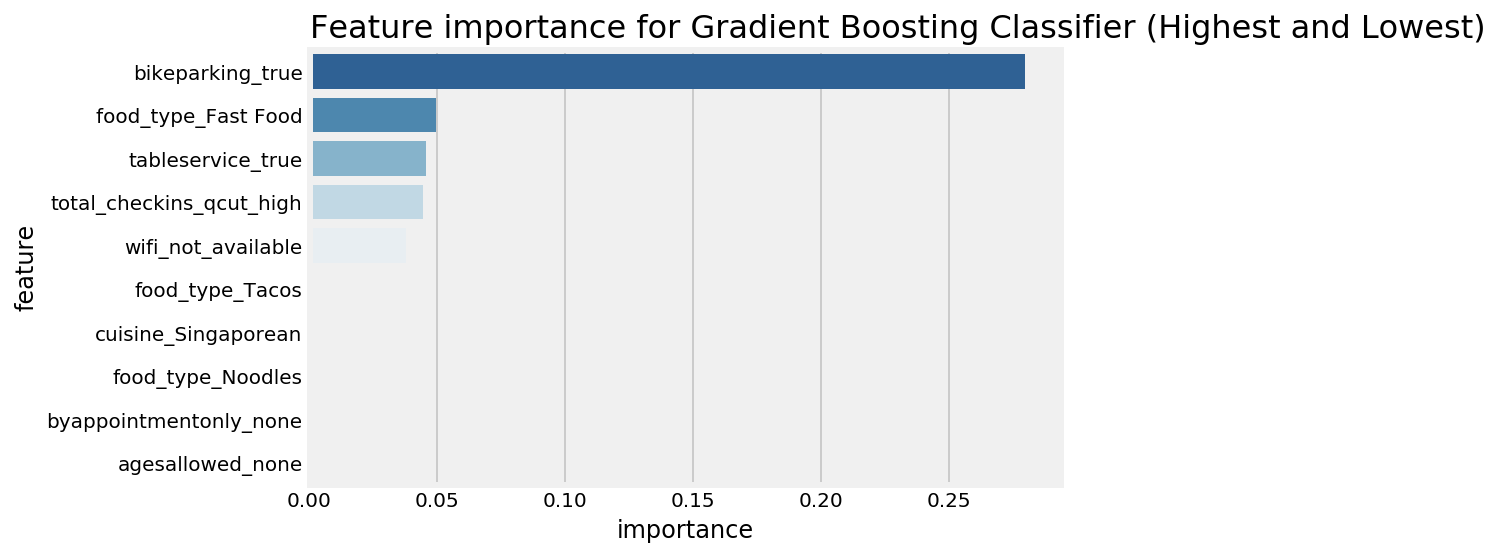

In [59]:
# Plot the feature importance table
sort_gb_model_result = pd.concat([gb_model_result.sort_values(by='importance', ascending=False).head(5),
                      gb_model_result.sort_values(by='importance', ascending=False).tail(5)])
sns.barplot(y = sort_gb_model_result.feature, x = gb_model_result.importance, palette = "RdBu_r")
plt.title("Feature importance for Gradient Boosting Classifier (Highest and Lowest)", loc = 'left', fontsize = 16)
plt.show()

# Use a Decision Tree Classifier

In [48]:
# Prepare the datasets
ydtc = y.copy()
Xdtc = X.copy()

Xdtc_train, Xdtc_test, ydtc_train, ydtc_test = train_test_split(Xdtc, ydtc, test_size=0.5, random_state=8)

In [49]:
# Fit the model
dt_classifier = DecisionTreeClassifier(criterion='gini',
                                    max_depth=None, 
                                    random_state=1)
dt_classifier.fit(Xdtc_train, ydtc_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

In [101]:
# Check the evaluation scores
print(dt_classifier.score(Xdtc_train, ydtc_train))
print(cross_val_score(dt_classifier, Xdtc_train, ydtc_train, cv=5).mean())
print(dt_classifier.score(Xdtc_test, ydtc_test))

0.9640595644005289
0.6886782607454653
0.6870781434834041


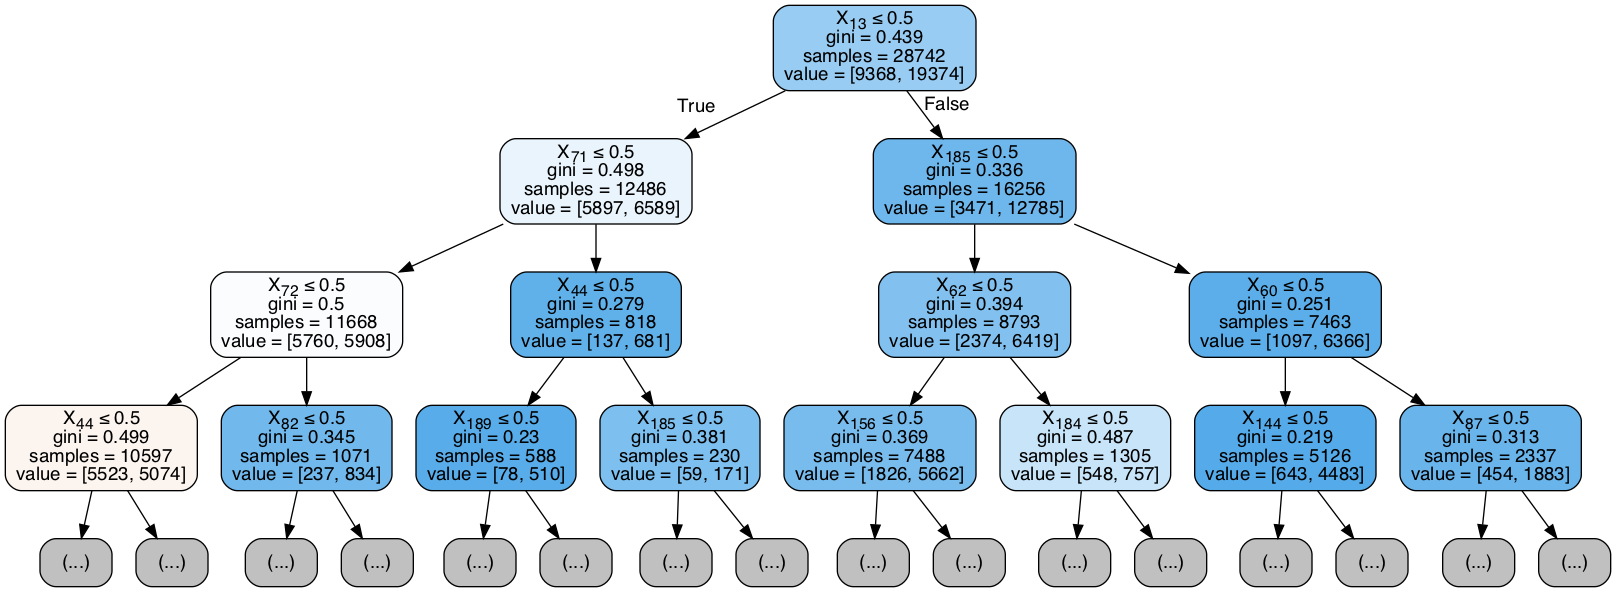

In [102]:
# Plot the results
dot_data = StringIO()
export_graphviz(dt_classifier,
                out_file=dot_data,
                filled=True,
                rounded=True,
                special_characters=True,
                max_depth = 3
                #feature_names=iris.feature_names
                )

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

Image(graph.create_png())

In [50]:
# Check the precision and recall scores
yhat_dt_classifier = dt_classifier.predict(Xdtc_test)
yhat_pp_dt_classifier = dt_classifier.predict_proba(Xdtc_test)
print(classification_report(ydtc_test, yhat_dt_classifier))

              precision    recall  f1-score   support

           0       0.53      0.53      0.53      9528
           1       0.77      0.76      0.76     19214

   micro avg       0.69      0.69      0.69     28742
   macro avg       0.65      0.65      0.65     28742
weighted avg       0.69      0.69      0.69     28742



In [51]:
# Check the misclassified items
pred_list_dt_classifier = dt_classifier.predict_proba(Xdtc_train)
pred_result_dt_classifier = pd.DataFrame(pred_list_dt_classifier, ydtc_train)
pred_result_dt_classifier['actual'] = dt_classifier.predict(Xdtc_train)
pred_result_dt_classifier.reset_index(inplace=True)

misclassified_dt_classifier = pred_result_dt_classifier[pred_result_dt_classifier.prediction_col != pred_result_dt_classifier.actual]
misclassified_dt_classifier = misclassified_dt_classifier.reindex(columns=['prediction_col', 'actual', 0, 1])
misclassified_dt_classifier['difference'] = (misclassified_dt_classifier[0] - misclassified_dt_classifier[1]).round(2)
misclassified_dt_classifier[:5]

,prediction_col,actual,0,1,difference
3,1,0,0.571429,0.428571,0.14
23,1,0,0.500000,0.500000,0.00
50,0,1,0.166667,0.833333,-0.67
68,0,1,0.083333,0.916667,-0.83
76,0,1,0.260870,0.739130,-0.48


In [52]:
# Check the feature importance table
dt_classifier_result = pd.DataFrame(dt_classifier.feature_importances_,
             columns=['importance'],
             index=X.columns,
             ).sort_values(by='importance', ascending=False
                           ).reset_index()
dt_classifier_result.rename(columns={'index': 'feature'}, inplace=True)
dt_classifier_result[:5]

,feature,importance
0,bikeparking_true,0.083654
1,businessacceptscreditcards_true,0.031252
2,outdoorseating_true,0.028022
3,average_stars_per_business_qcut_medium,0.026732
4,wifi_free,0.025588


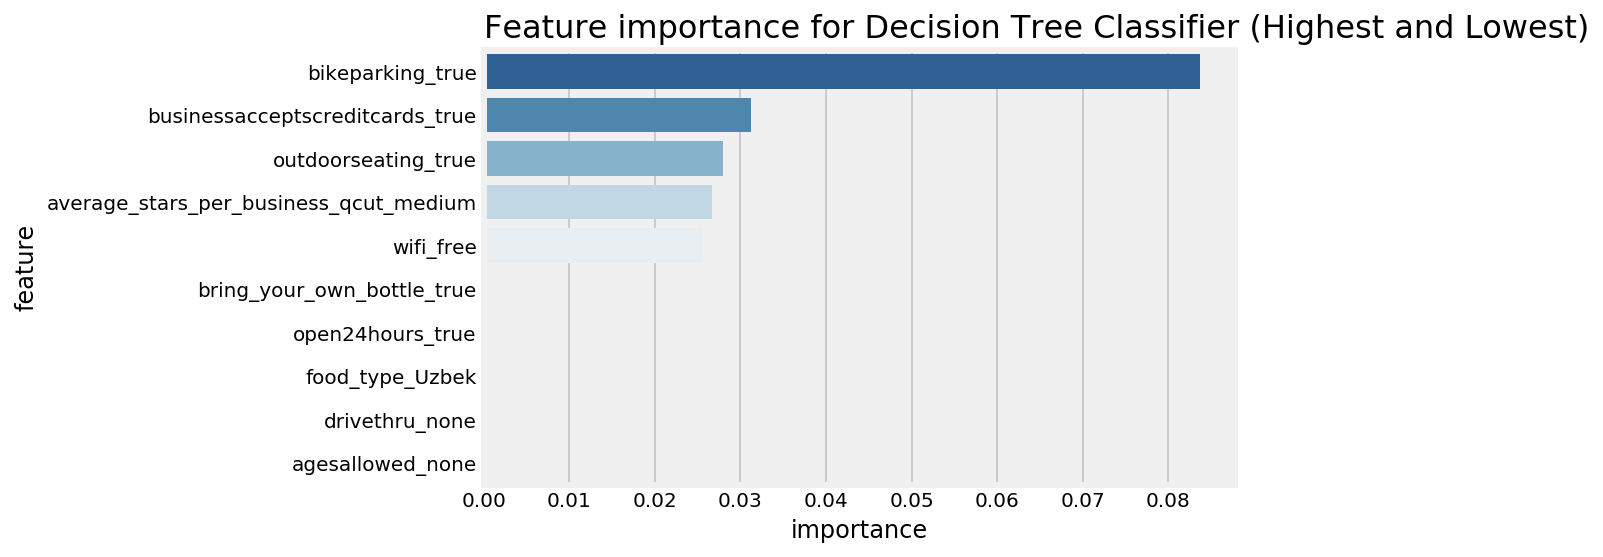

In [53]:
# Plot the feature importance table
dt_classifier_model_result = pd.concat([dt_classifier_result.sort_values(by='importance', ascending=False).head(5),
                      dt_classifier_result.sort_values(by='importance', ascending=False).tail(5)])
sns.barplot(y = dt_classifier_model_result.feature, x = dt_classifier_model_result.importance, palette = "RdBu_r")
plt.title("Feature importance for Decision Tree Classifier (Highest and Lowest)", loc = 'left', fontsize = 16)
plt.show()

# Use grid search for the regression and classification decision tree

In [257]:
# Prepare the datasets
y_cgrid = y.copy()
X_cgrid = X.copy()

Xcgrid_train, Xcgrid_test, y_cgrid_train, y_cgrid_test = train_test_split(X_cgrid, y, test_size=0.5, random_state=8)


Xcgrid_train = scaler.fit_transform(Xcgrid_train)
Xcgrid_test = scaler.transform(Xcgrid_test)

In [259]:
# Fit the model
tree_params = {'max_depth': np.arange(1, 100, 10)}

dt_gridsearch = GridSearchCV(dt_classifier,
                              tree_params,
                              n_jobs=2, 
                              cv=5, 
                              verbose=1)

dt_gridsearch.fit(Xcgrid_train, y_cgrid_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   15.0s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   16.2s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'max_depth': array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [260]:
# Check the parameters
dt_gridsearch.param_grid

{'max_depth': array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91])}

In [261]:
# Check the best score
dt_gridsearch.best_score_

0.735091503722775

In [262]:
# Check the evaluation scores
print(dt_gridsearch.score(Xcgrid_train, y_cgrid_train))
print(cross_val_score(dt_gridsearch, Xcgrid_train, y_cgrid_train, cv=5).mean())
print(dt_gridsearch.score(Xcgrid_test, y_cgrid_test))

0.7829656948020318
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    8.2s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    9.0s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    7.9s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    8.7s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    8.3s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    9.1s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    8.3s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    9.1s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.2s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   11.5s finished


0.7350913920535408
0.7346044116623757


In [263]:
# Check the precision and recall scores
yhat_dt_gridsearch = dt_gridsearch.predict(Xcgrid_test)
yhat_pp_dt_gridsearch = dt_gridsearch.predict_proba(Xcgrid_test)
print(classification_report(y_cgrid_test, yhat_dt_gridsearch))

              precision    recall  f1-score   support

           0       0.62      0.51      0.56      9528
           1       0.78      0.85      0.81     19214

   micro avg       0.73      0.73      0.73     28742
   macro avg       0.70      0.68      0.69     28742
weighted avg       0.73      0.73      0.73     28742



In [264]:
# Create a feature importance table
feature_importances = dt_gridsearch.best_estimator_.feature_importances_

In [265]:
feature_importance_cgrid = pd.DataFrame(list(zip(X_cgrid.columns, dt_gridsearch.best_estimator_.feature_importances_)), 
             columns=['Feature', 'Importance']
            ).sort_values(by='Importance', ascending=False)
#feature_importance_cgrid

# SVM classifiers

In [37]:
# Prepare the datasets
X_svm = X.copy()
y_svm = y.copy()

Xsvm_train, Xsvm_test, y_svm_train, y_svm_test = train_test_split(X_svm, y_svm, test_size=0.5, random_state=8)

Xsvm_train = scaler.fit_transform(Xsvm_train)
Xsvm_test = scaler.transform(Xsvm_test)

/Users/mai/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/mai/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/mai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  import sys


In [38]:
# Check the distribution of y values
y_svm.value_counts(normalize=True).max()

0.6712824438104517

In [39]:
# Fit the model
clf = svm.SVC(gamma='auto', probability=True)
clf.fit(Xsvm_train, y_svm_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [41]:
# Check the evaluation scores
print(clf.score(Xsvm_train, y_svm_train))
print(clf.score(Xsvm_test, y_svm_test))

0.7954909192123025
0.7516874260663837


In [42]:
# Check the cv score
print(cross_val_score(clf, Xsvm_train, y_svm_train, cv=5, scoring='accuracy').mean())

0.7569756073341444


In [40]:
# Check precision and recall scores
yhat_clf = clf.predict(Xsvm_test)
yhat_pp_clf = clf.predict_proba(Xsvm_test)
print(classification_report(y_svm_test, yhat_clf))

              precision    recall  f1-score   support

           0       0.71      0.43      0.53      9528
           1       0.76      0.91      0.83     19214

   micro avg       0.75      0.75      0.75     28742
   macro avg       0.74      0.67      0.68     28742
weighted avg       0.74      0.75      0.73     28742



--------

In [275]:
# Fit the model
clf_gscale = svm.SVC(gamma='scale', probability=True)
clf_gscale.fit(Xsvm_train, y_svm_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [278]:
# Check the evaluation scores
print(clf_gscale.score(Xsvm_train, y_svm_train))
print(clf_gscale.score(Xsvm_test, y_svm_test))
print(cross_val_score(clf_gscale, Xsvm_train, y_svm_train, cv=5, scoring='accuracy').mean())

0.795978011272702
0.7514786723262125
0.7568016640375521


In [276]:
# Check precision and recall scores
yhat_clf_gscale = clf_gscale.predict(Xsvm_test)
yhat_pp_clf_gscale = clf_gscale.predict_proba(Xsvm_test)
print(classification_report(y_svm_test, yhat_clf_gscale))

              precision    recall  f1-score   support

           0       0.71      0.43      0.53      9528
           1       0.76      0.91      0.83     19214

   micro avg       0.75      0.75      0.75     28742
   macro avg       0.73      0.67      0.68     28742
weighted avg       0.74      0.75      0.73     28742



# Use a BaggingClassifier with a KNN base estimator (To Be Done)

In [ ]:
X_bcknn = X.copy()
y_bcknn = y.copy()

Xbcknn_train, Xbcknn_test, y_bcknn_train, y_bcknn_test = train_test_split(X_bcknn, y_bcknn, test_size=0.5, random_state=8)

Xcgrid_train = scaler.fit_transform(Xbcknn_train)
Xcgrid_test = scaler.transform(Xbcknn_test)

In [ ]:
bcknn_model = BaggingClassifier(base_estimator=knn, n_estimators=5)
params = {'max_samples': np.linspace(0.8, 1.0, 3),
           'max_features': range(int(3/4.*X_bcknn.shape[1]), X_bcknn.shape[1]+1)}

bcknn_grid = GridSearchCV(bcknn_model, param_grid=params, cv=5)

In [ ]:
bcknn_grid.fit(Xbcknn_train, y_bcknn_train)
bcknn_grid.best_estimator_
print(bcknn_grid.score(Xbcknn_train, y_bcknn_train))
print(bcknn_grid.best_score_)
print(bcknn_grid.score(Xbcknn_test, y_bcknn_test))

In [ ]:
yhat_bcknn_grid = bcknn_grid.predict(Xbcknn_test)
yhat_pp_bcknn_grid = bcknn_grid.predict_proba(Xbcknn_test)
print(classification_report(y_bcknn_test, yhat_lr_ridge))

In [ ]:
bcknn_feature_importances = bcknn_grid.best_estimator_.feature_importances_
bcknn_feature_importances = np.mean([tree.feature_importances_ for tree in bcknn_grid.estimators_], axis=0)
bcknn_feature_importances.head()

# Plot scores for evaluation

In [93]:
# Load data
Q2_result_df = pd.read_pickle('/Users/mai/Desktop/yelp_dataset/to_submit/Q2_result_df.pickle')

In [197]:
# Overall, test accuracy and cross validation scores of all models were very close. 
Q2_result_df

,Model,Train_Score,Test_Score,CV_Score,Precision_Score,Recall_Score,Baseline
0,Logistic_RegressionCV_Ridge,0.75,0.74,0.74,0.76,0.90,0.67
1,Logistic_RegressionCV_Lasso,0.74,0.74,0.74,0.76,0.88,0.67
2,Logistic_Regression_GridsearchCV,0.74,0.74,0.74,0.77,0.88,0.67
3,KNeighbors Classifier,0.80,0.71,0.71,0.76,0.82,0.67
4,Ada Boost Classifier,0.78,0.75,0.75,0.79,0.86,0.67
5,Gradient Boosting Classifier,0.78,0.76,0.75,0.79,0.87,0.67
6,Decision Tree Classifier,0.96,0.69,0.69,0.77,0.76,0.67
7,Decision_Tree_Classifier_GridsearchCV,0.78,0.73,0.74,0.78,0.85,0.67
8,SVM_classifiers_gamma_auto,0.80,0.75,0.76,0.76,0.91,0.67
9,SVM_classifiers_gamma_scale,0.80,0.75,0.76,0.76,0.91,0.67


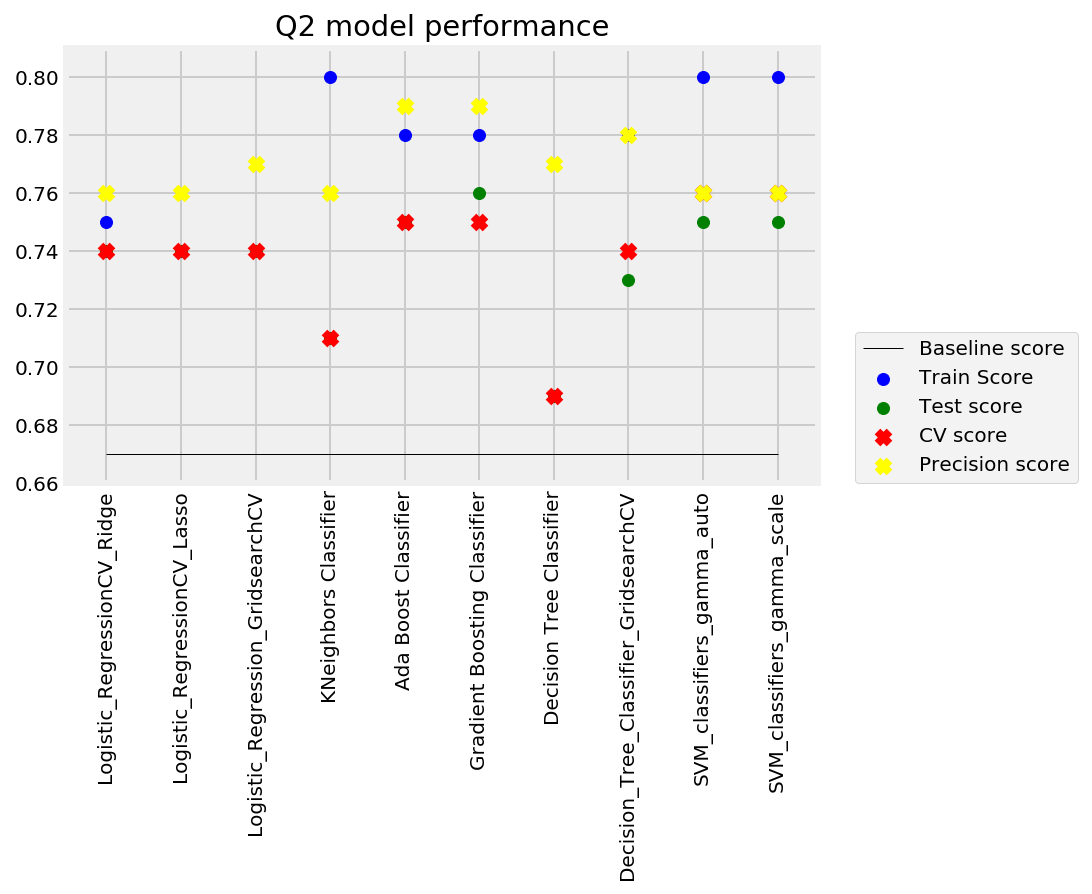

In [94]:
# Plot the results
fig, ax = plt.subplots()

plt.scatter(Q2_result_df['Model'], Q2_result_df['Train_Score'], 
                 color = 'blue', label = 'Train Score', marker = 'o')
plt.scatter(Q2_result_df['Model'], Q2_result_df['Test_Score'], 
                  color = 'green', label = 'Test score', marker = 'o')
plt.scatter(Q2_result_df['Model'], Q2_result_df['CV_Score'], 
                  color = 'red', label = 'CV score', marker = 'x')
plt.scatter(Q2_result_df['Model'], Q2_result_df['Precision_Score'], 
                  color = 'yellow', label = 'Precision score', marker = 'x')
plt.plot(Q2_result_df['Model'], Q2_result_df['Baseline'], 
               color = 'black', label = 'Baseline score', linewidth=0.5)

plt.xticks(rotation = 90)
plt.title('Q2 model performance')
plt.legend(loc=(1.05,0))
axes = plt.gca()
axes.set_ylim([0.66, 0.81])
plt.savefig('Q2_model_performance.jpg', bbox_inches="tight")
plt.show();

In [122]:
# Plot the ROC curve
fpr, tpr, threshold = roc_curve(y_test, yhat_pp_ridge[:, 1])
roc_auc = auc(fpr, tpr)

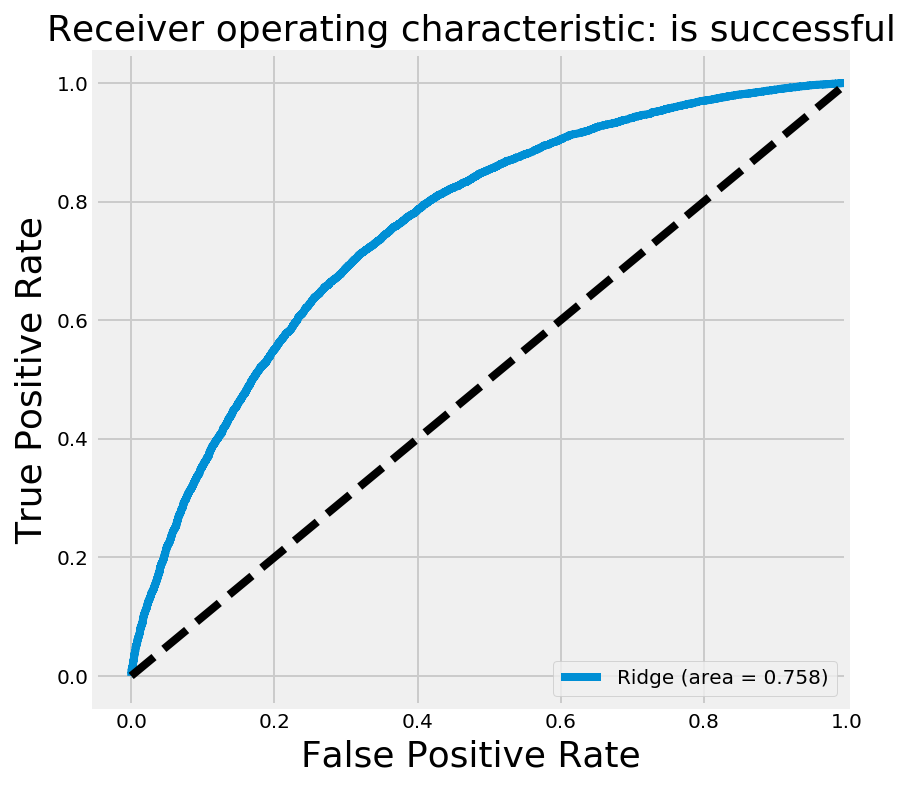

In [123]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(fpr, tpr, label='Ridge (area = %0.3f)' % roc_auc, linewidth=4)
ax.plot([0, 1], [0, 1], 'k--', linewidth=4)

ax.set_xlim([-0.05, 1.0])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=18)
ax.set_ylabel('True Positive Rate', fontsize=18)
ax.set_title('Receiver operating characteristic: is successful', fontsize=18)
ax.legend(loc="lower right")

plt.show()

In [124]:
fpr, tpr, threshold = roc_curve(y_test, yhat_pp_lasso[:, 1])
roc_auc = auc(fpr, tpr)

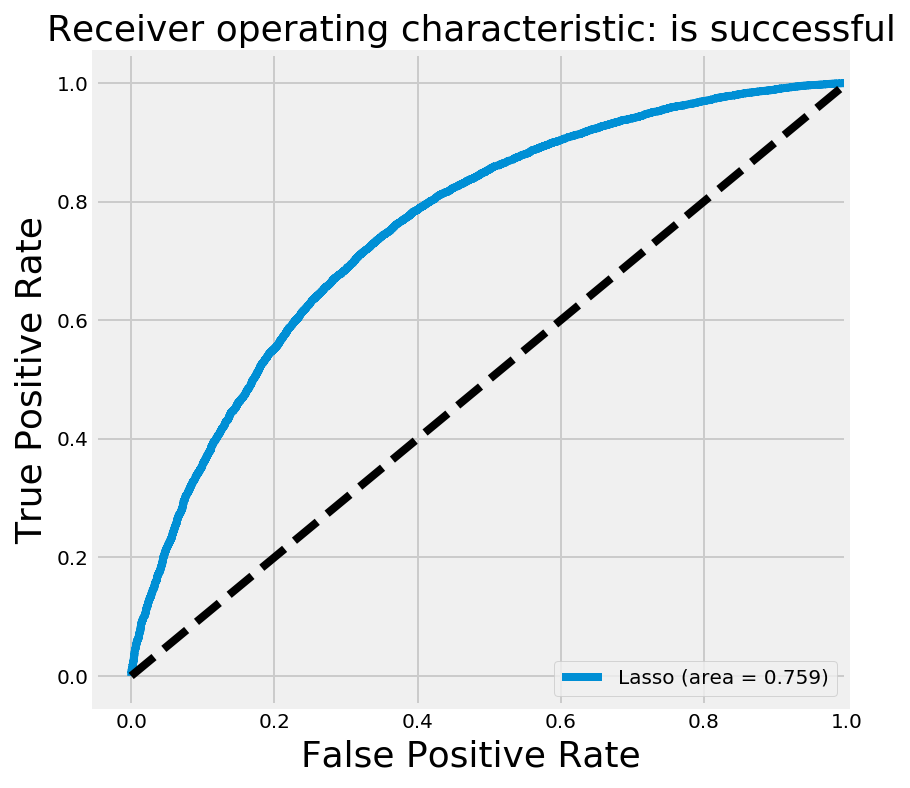

In [125]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(fpr, tpr, label='Lasso (area = %0.3f)' % roc_auc, linewidth=4)
ax.plot([0, 1], [0, 1], 'k--', linewidth=4)

ax.set_xlim([-0.05, 1.0])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=18)
ax.set_ylabel('True Positive Rate', fontsize=18)
ax.set_title('Receiver operating characteristic: is successful', fontsize=18)
ax.legend(loc="lower right")

plt.show()

In [126]:
fpr_gb, tpr_gb, threshold = roc_curve(ygb_test, yhat_pp_gb_model[:, 1])
roc_auc_gb = auc(fpr_gb, tpr_gb)

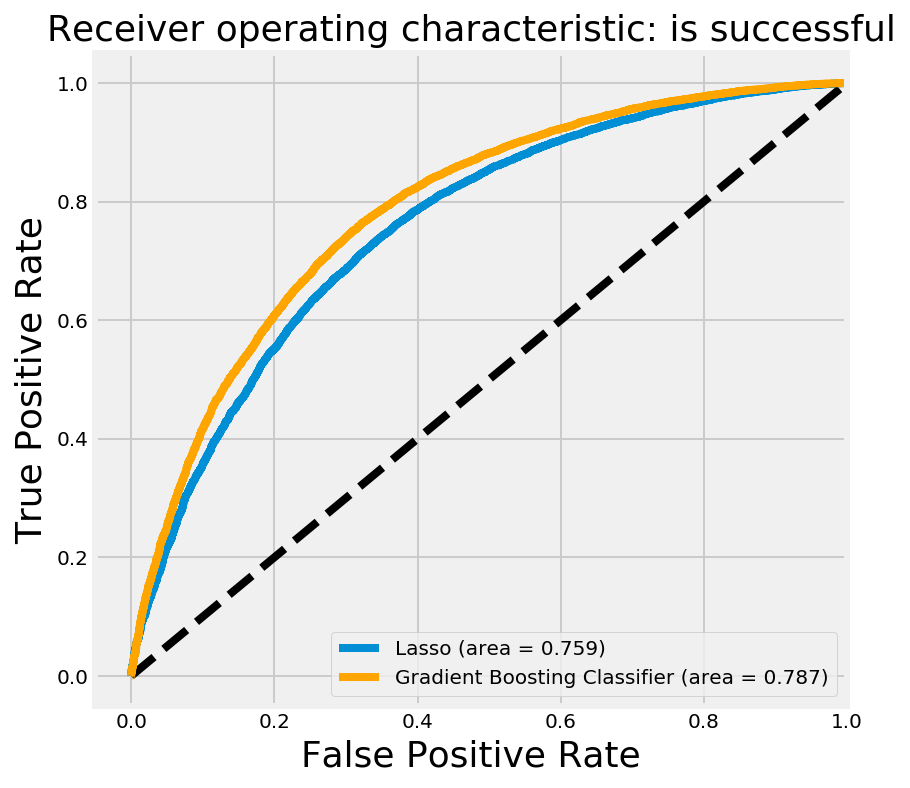

In [127]:
ax.plot(fpr_gb, tpr_gb, label='Gradient Boosting Classifier (area = %0.3f)' % roc_auc_gb,
        linewidth=4, color='orange')
ax.legend(loc='lower right')
fig

In [128]:
fpr_dtc, tpr_dtc, threshold = roc_curve(ydtc_test, yhat_pp_dt_classifier[:, 1])
roc_auc_dtc = auc(fpr_dtc, tpr_dtc)

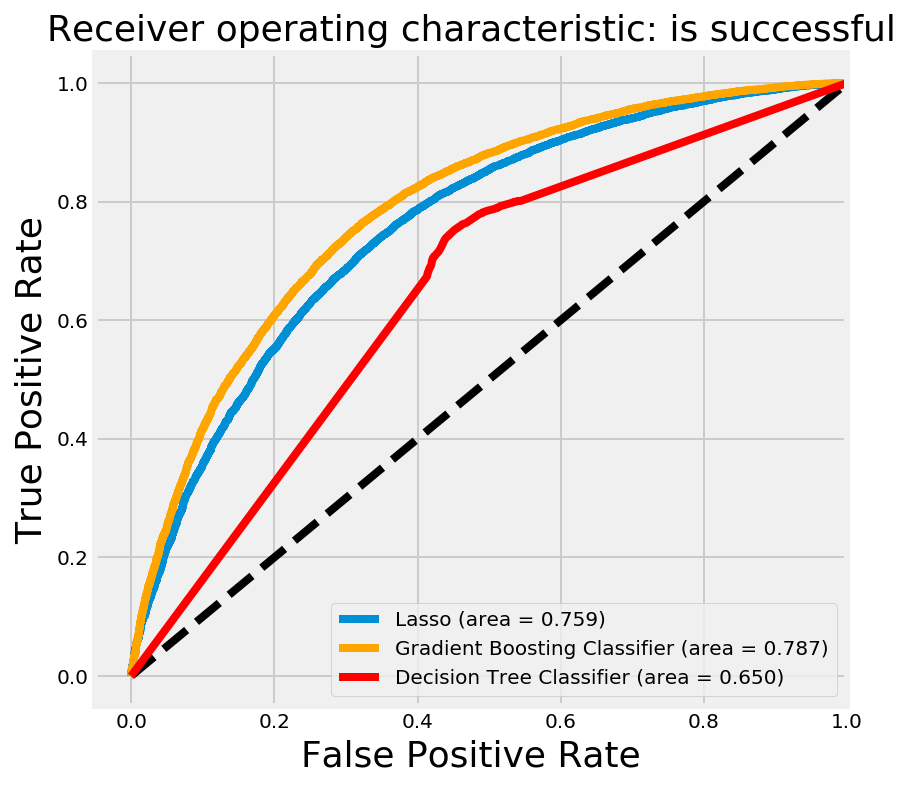

In [129]:
ax.plot(fpr_dtc, tpr_dtc, label='Decision Tree Classifier (area = %0.3f)' % roc_auc_dtc,
        linewidth=4, color='red')
ax.legend(loc='lower right')
fig